In [1]:
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, Concatenate, Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate, Convolution2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1
from lib.preprocess_modules import load_pkl, save_pkl
from lib.dl_modules import *
#from sklearn.preprocessing import normalize
from config import *
from pathlib import Path
from numpy.random import shuffle, seed
import gc
import matplotlib.pyplot as plt
import os

In [2]:
# '''
# Generate final dataset from separate files.
# X: array of n_files*64*64
# y: array of n_files*16*16
# Save to pkl files.
# '''
# n_files=0

# for fname in os.listdir(foils_pkl_path):
#     if fname[:2].lower() in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]:   
#         n_files +=1


# X = np.zeros((n_files, 16, 32, 6))
# y = np.zeros((n_files, 128))

# sample = 0
# for fname in os.listdir(foils_pkl_path):
#     if fname[:2].lower() in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]:
#         foil = load_pkl(Path(foils_pkl_path, fname))
#         x_layer=0
#         for layer_n in [0,1,2,3,6,7]:
# #         for layer_n in range(X.shape[3]):
#             X[sample, :, :, x_layer] = foil['X'][layer_n, ...]
#             x_layer+=1
# #             if layer_n==6: break
# #                 X[..., layer_n] = X[..., layer_n]/re_max
# #             if layer_n==7:
# #                 X[..., layer_n] = X[..., layer_n]/alfa_max
#         y[sample, :] = foil['y'].y.reshape(128)
#         sample+=1
#         if sample>n_files-1:
           
#             break
    
# assert np.sum(np.isnan(X))==0, "NaNs in X"
# assert np.sum(np.isnan(y))==0, "NaNs in y"

# save_pkl(X, Path(foils_pkl_path, "X.pkl"))
# save_pkl(y, Path(foils_pkl_path, "y.pkl"))

In [112]:
'''
Generate final dataset from separate files.
X: array of n_files*
y: array of n_files*
Save to pkl files.
'''
n_X_layers = 7
n_files=64
X = np.zeros((n_files, 16, 32, n_X_layers))
y = np.zeros((n_files, 128))

sample = 0

for fname in os.listdir(foils_pkl_path): # сперва нужные профили
    if sample>n_files-1:break
    if fname[:2].lower() in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]:
        foil = load_pkl(Path(foils_pkl_path, fname))
        for layer_n in range(X.shape[3]):
            X[sample, :, :, layer_n] = foil['X'][layer_n, ...]
        y[sample, :] = foil['y'].y.reshape(128)
        sample+=1

for fname in os.listdir(foils_pkl_path): # потом все оставшиеся
    if sample>n_files-1:break
    if fname[:2].lower() not in ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]:
        foil = load_pkl(Path(foils_pkl_path, fname))
        for layer_n in range(X.shape[3]):
            X[sample, :, :, layer_n] = foil['X'][layer_n, ...]
        y[sample, :] = foil['y'].y.reshape(128)
        sample+=1
    
assert np.sum(np.isnan(X))==0, "NaNs in X"
assert np.sum(np.isnan(y))==0, "NaNs in y"

save_pkl(X, Path(foils_pkl_path, "X.pkl"))
save_pkl(y, Path(foils_pkl_path, "y.pkl"))

print("Totally foils in arrays: %i" % (sample))

Totally foils in arrays: 64


In [113]:
X = load_pkl(Path(foils_pkl_path, 'X.pkl'))
y = load_pkl(Path(foils_pkl_path, 'y.pkl'))
# X = X.reshape(X.shape[0],16,16,16)
X.shape, y.shape

((64, 16, 32, 7), (64, 128))

In [114]:
all_indices = np.arange(len(X))
seed(42)
shuffle(all_indices)

n_indices = len(X)
train_part = int(n_indices*train_percentage)
val_part = int(n_indices*val_percentage)
train_part, val_part
train_indices = all_indices[:train_part]
val_indices = all_indices[train_part:val_part]
test_indices = all_indices[val_part:]

In [115]:
def define_unet_9(input_shape=(16, 32, 4), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # contracting path only
    inputs = Input(shape=input_shape)
    
    bn1 = BatchNormalization()(inputs)
       
    conv1 = Convolution2D(4, (2,2), activation='tanh', padding='same')(bn1)
    conv1 = Convolution2D(4, (2,2), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    flat = Flatten()(pool4)
    
    dense = Dense(2048, activation='tanh')(flat)
    dense = Dense(128, activation='tanh')(dense)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
#         model.layers[layer].kernel_initializer=1e-12
#         model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model

def define_unet_10(input_shape=(16, 32, 4), optimizer=Adam(1e-5), lr=1e-5, reg=0):
  
    inputs = Input(shape=input_shape)
    
    bn1 = BatchNormalization()(inputs)
    
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(bn1)
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(conv5)

    up6 = Concatenate()([Convolution2D(256, (2, 2), activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv5)), conv4])
    conv6 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(up6)
    conv6 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv6)

    up7 = Concatenate()([Convolution2D(128, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv6)), conv3])
    conv7 = Convolution2D(512, (2,2), activation='tanh', padding='same')(up7)
    conv7 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv7)
    
    up8 = Concatenate()([Convolution2D(64, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv7)), conv2])
    conv8 = Convolution2D(256, (2,2), activation='tanh', padding='same')(up8)
    conv8 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv8)
    
    up9 = Concatenate()([Convolution2D(32, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv8)), conv1])
    conv9 = Convolution2D(16, (2,2), activation='tanh', padding='same')(up9)
    conv9 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv9)
    
    conv10 = Convolution2D(1, (1, 1), activation='tanh')(conv9)

    flat = Flatten()(conv10)
    
    dense = Dense(2048, activation='tanh')(flat)
    dense = Dense(128, activation='tanh')(dense)
        
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
#         model.layers[layer].kernel_initializer=1e-12
#         model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model



model = define_unet_9(input_shape=(16,32,4), optimizer=Adam(1), lr=1e-4, reg=1e-2)

U-Net compiled
Input shape: (None, 16, 32, 4)
Output shape: (None, 128)


In [116]:
# for layer in model.layers:
#     try:   
#         print(layer.output_shape)
#     except:
#         pass

In [117]:
# training
gc.collect()

# n_epochs=20
# batch_size=16
# lr=5e-5
# reg=0.01

n_epochs=10000
batch_size=1
lr=1e-5
reg=0.001
optimizer=Adam(learning_rate=lr)

model = define_unet_9(input_shape=X[0].shape, optimizer=optimizer, lr=lr, reg=reg)

# model.load_weights(str(Path("./weights", 'initial_weights_300foils_04122020.h5')))

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size, Xdim=X[0].shape)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size, Xdim=X[0].shape)
test_generator  = BatchGenerator(X, y, test_indices, batch_size=batch_size, Xdim=X[0].shape, shuffle=False)

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=10, factor=0.2, patience=10, verbose=1, mode='min')
# lr_reduce = CosineLR(min_lr=1e-12, max_lr=lr, steps_per_epoch=np.ceil(len(train_indices)/batch_size), lr_decay=0.9)
# m_save = ModelCheckpoint(str(Path(results_path, 'weights', 'temp_weights.h5')), monitor='val_mse', 
#                          verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce],#, m_save],                              
                             verbose=1, workers=1, use_multiprocessing=False)

# save history and weights
# r_name = (str(datetime.now())[:16]).replace(':','-')
# unet.save_weights(str(Path(results_path,'weights', r_name+'.h5')))
# save_pkl(history.history, Path(results_path,'weights', r_name+'.pkl'))

print('Done.')

U-Net compiled
Input shape: (None, 16, 32, 7)
Output shape: (None, 128)
Epoch 1/10000
48/48 [==============================] - 6s 121ms/step - loss: 4.8989e-04 - mse: 4.8989e-04 - val_loss: 6.0648e-04 - val_mse: 6.0648e-04 - lr: 1.0000e-05
Epoch 2/10000
48/48 [==============================] - 6s 116ms/step - loss: 1.4313e-04 - mse: 1.4313e-04 - val_loss: 5.1534e-04 - val_mse: 5.1534e-04 - lr: 1.0000e-05
Epoch 3/10000
48/48 [==============================] - 6s 116ms/step - loss: 1.1005e-04 - mse: 1.1005e-04 - val_loss: 3.6407e-04 - val_mse: 3.6407e-04 - lr: 1.0000e-05
Epoch 4/10000
48/48 [==============================] - 6s 116ms/step - loss: 8.8124e-05 - mse: 8.8124e-05 - val_loss: 3.5688e-04 - val_mse: 3.5688e-04 - lr: 1.0000e-05
Epoch 5/10000
48/48 [==============================] - 6s 116ms/step - loss: 7.6065e-05 - mse: 7.6065e-05 - val_loss: 2.8525e-04 - val_mse: 2.8525e-04 - lr: 1.0000e-05
Epoch 6/10000
48/48 [==============================] - 6s 116ms/step - loss: 6.5755e-05 

Epoch 94/10000
48/48 [==============================] - 5s 114ms/step - loss: 1.0812e-05 - mse: 1.0812e-05 - val_loss: 2.7645e-04 - val_mse: 2.7645e-04 - lr: 1.6000e-08
Epoch 95/10000
48/48 [==============================] - 6s 115ms/step - loss: 1.0798e-05 - mse: 1.0798e-05 - val_loss: 2.7658e-04 - val_mse: 2.7658e-04 - lr: 1.6000e-08
Epoch 96/10000
48/48 [==============================] - 5s 114ms/step - loss: 1.0795e-05 - mse: 1.0795e-05 - val_loss: 2.7649e-04 - val_mse: 2.7649e-04 - lr: 1.6000e-08
Epoch 97/10000
48/48 [==============================] - ETA: 0s - loss: 1.0797e-05 - mse: 1.0797e-05
Epoch 00097: ReduceLROnPlateau reducing learning rate to 3.1999999094978194e-09.
48/48 [==============================] - 5s 114ms/step - loss: 1.0797e-05 - mse: 1.0797e-05 - val_loss: 2.7589e-04 - val_mse: 2.7589e-04 - lr: 1.6000e-08
Epoch 98/10000
48/48 [==============================] - 5s 113ms/step - loss: 1.0772e-05 - mse: 1.0772e-05 - val_loss: 2.7613e-04 - val_mse: 2.7613e-04 - lr:

48/48 [==============================] - 5s 114ms/step - loss: 1.0762e-05 - mse: 1.0762e-05 - val_loss: 2.7677e-04 - val_mse: 2.7677e-04 - lr: 5.1200e-12
Epoch 186/10000
48/48 [==============================] - 5s 114ms/step - loss: 1.0762e-05 - mse: 1.0762e-05 - val_loss: 2.7606e-04 - val_mse: 2.7606e-04 - lr: 5.1200e-12
Epoch 187/10000
48/48 [==============================] - 5s 114ms/step - loss: 1.0762e-05 - mse: 1.0762e-05 - val_loss: 2.7669e-04 - val_mse: 2.7669e-04 - lr: 5.1200e-12
Epoch 188/10000
48/48 [==============================] - 5s 114ms/step - loss: 1.0762e-05 - mse: 1.0762e-05 - val_loss: 2.7658e-04 - val_mse: 2.7658e-04 - lr: 5.1200e-12
Epoch 189/10000
48/48 [==============================] - 5s 114ms/step - loss: 1.0762e-05 - mse: 1.0762e-05 - val_loss: 2.7635e-04 - val_mse: 2.7635e-04 - lr: 5.1200e-12
Epoch 190/10000
48/48 [==============================] - 5s 114ms/step - loss: 1.0762e-05 - mse: 1.0762e-05 - val_loss: 2.7673e-04 - val_mse: 2.7673e-04 - lr: 5.1200e

0.07256468


[]

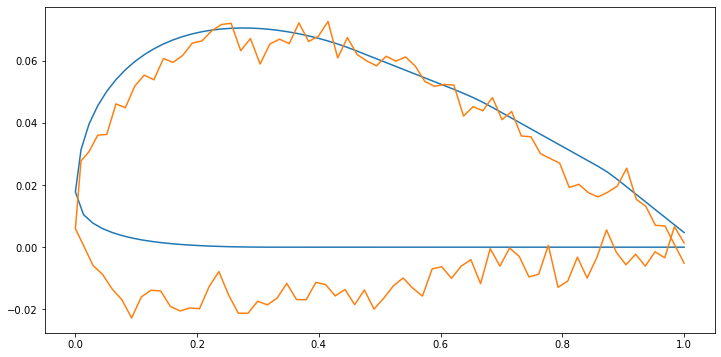

In [119]:
X_pred, y_targ = test_generator[0]
X_pred = X_pred[0]
y_targ = y_targ[0]
y_pred = model.predict(np.expand_dims(X_pred,axis=0))
print(np.max(y_pred))
plt.figure(figsize=(12,6))
plt.plot(foil['y'].x, y_targ), plt.plot(foil['y'].x, y_pred[0,])#, plt.plot([0,0],[-0.3,0.3])
plt.plot()

In [17]:
X_pred.shape


(16, 32, 4)

In [30]:
for i, _ in enumerate(test_generator):
    a, b = test_generator[i]
    print(np.max(b))
    

0.10805403181651126
0.09349667875105727
0.09349381105285037
0.09035233992894652
0.07863152720333667
0.119013378313855
0.05892802179134889
0.05939866890947117
0.047171300384526174
0.06048534209968928
0.05188243859065457
0.054179565161679114
0.0900383017473756
0.09868313198702476


In [27]:
X_pred[0].shape

(64, 64, 1)

In [74]:
# model.save_weights(str(Path("./weights", 'initial_weights_1000foils_04122020.h5')))

In [41]:
def define_unet_1(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   
    inputs = Input(shape=input_shape)
    bn1 = BatchNormalization()(inputs)
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(bn1)
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv1)
    bn2 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn2)
    
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv2)
    bn3 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn3)
    
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv3)
    bn4 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn4)
    
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv4)
    bn5 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn5)
    
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(conv5)
    bn6 = BatchNormalization()(conv5)
    up6 = Concatenate()([Convolution2D(256, (2, 2), activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(bn6)), conv4])
    conv6 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(up6)
    conv6 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv6)
    bn7 = BatchNormalization()(conv6)
    up7 = Concatenate()([Convolution2D(128, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(bn7)), conv3])
    conv7 = Convolution2D(512, (2,2), activation='tanh', padding='same')(up7)
    conv7 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv7)
    bn8 = BatchNormalization()(conv7)
    up8 = Concatenate()([Convolution2D(64, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(bn8)), conv2])
    conv8 = Convolution2D(256, (2,2), activation='tanh', padding='same')(up8)
    conv8 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv8)
    bn9 = BatchNormalization()(conv8)
    up9 = Concatenate()([Convolution2D(32, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(bn9)), conv1])
    conv9 = Convolution2D(16, (2,2), activation='tanh', padding='same')(up9)
    conv9 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv9)
    
    bn10 = BatchNormalization()(conv9)
    
    conv10 = Convolution2D(1, (1, 1), activation='tanh')(bn10)
    
    flat = Flatten()(conv10)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model

def define_unet_2(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # no bn
    inputs = Input(shape=input_shape)
    
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(inputs)
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(conv5)

    up6 = Concatenate()([Convolution2D(256, (2, 2), activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv5)), conv4])
    conv6 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(up6)
    conv6 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv6)

    up7 = Concatenate()([Convolution2D(128, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv6)), conv3])
    conv7 = Convolution2D(512, (2,2), activation='tanh', padding='same')(up7)
    conv7 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv7)
    
    up8 = Concatenate()([Convolution2D(64, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv7)), conv2])
    conv8 = Convolution2D(256, (2,2), activation='tanh', padding='same')(up8)
    conv8 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv8)
    
    up9 = Concatenate()([Convolution2D(32, (2, 2),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv8)), conv1])
    conv9 = Convolution2D(16, (2,2), activation='tanh', padding='same')(up9)
    conv9 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv9)
    
    conv10 = Convolution2D(1, (1, 1), activation='tanh')(conv9)

    flat = Flatten()(conv10)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model

def define_unet_3(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # contracting path only
    inputs = Input(shape=input_shape)
       
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(inputs)
    conv1 = Convolution2D(16, (2,2), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (2,2), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (2,2), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (2,2), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(conv5)

    flat = Flatten()(conv5)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model


def define_unet_4(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # no bn
    inputs = Input(shape=input_shape)
    
    conv1 = Convolution2D(16, (3,3), activation='tanh', padding='same')(inputs)
    conv1 = Convolution2D(16, (3,3), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (3,3), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (3,3), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (3,3), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (3,3), activation='tanh', padding='same')(conv5)

    up6 = Concatenate()([Convolution2D(256, (3,3), activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv5)), conv4])
    conv6 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(up6)
    conv6 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(conv6)

    up7 = Concatenate()([Convolution2D(128, (3,3) ,activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv6)), conv3])
    conv7 = Convolution2D(512, (3,3), activation='tanh', padding='same')(up7)
    conv7 = Convolution2D(512, (3,3), activation='tanh', padding='same')(conv7)
    
    up8 = Concatenate()([Convolution2D(64, (3,3),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv7)), conv2])
    conv8 = Convolution2D(256, (3,3), activation='tanh', padding='same')(up8)
    conv8 = Convolution2D(256, (3,3), activation='tanh', padding='same')(conv8)
    
    up9 = Concatenate()([Convolution2D(32, (3,3),activation='tanh', padding='same')(UpSampling2D(size=(2, 2))(conv8)), conv1])
    conv9 = Convolution2D(16, (3,3), activation='tanh', padding='same')(up9)
    conv9 = Convolution2D(16, (3,3), activation='tanh', padding='same')(conv9)
    
    conv10 = Convolution2D(1, (1, 1), activation='tanh')(conv9)

    flat = Flatten()(conv10)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model

def define_unet_5(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # contracting path only
    inputs = Input(shape=input_shape)
       
    conv1 = Convolution2D(16, (3,3), activation='tanh', padding='same')(inputs)
    conv1 = Convolution2D(16, (3,3), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (3,3), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (3,3), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (3,3), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (1,1), activation='tanh', padding='same')(conv5)

    flat = Flatten()(conv5)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model

def define_unet_6(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # contracting path only
    inputs = Input(shape=input_shape)
       
    conv1 = Convolution2D(16, (3,3), activation='tanh', padding='same')(inputs)
    conv1 = Convolution2D(16, (3,3), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(256, (3,3), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(256, (3,3), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (3,3), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (1,1), activation='tanh', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    conv6 = Convolution2D(512, (3,3), activation='tanh', padding='same')(pool5)
    conv6 = Convolution2D(128, (1,1), activation='tanh', padding='same')(conv6)
    
    flat = Flatten()(conv5)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model

def define_unet_7(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # contracting path only
    inputs = Input(shape=input_shape)
       
    conv1 = Convolution2D(16, (4,4), activation='tanh', padding='same')(inputs)
    conv1 = Convolution2D(16, (4,4), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(64, (3,3), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(64, (3,3), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    conv6 = Convolution2D(512, (1,1), activation='tanh', padding='same')(pool5)
    conv6 = Convolution2D(128, (1,1), activation='tanh', padding='same')(conv6)
    
    flat = Flatten()(conv5)
    
    dense = Dense(128, activation='tanh')(flat)
    
    model = Model(inputs=inputs, outputs=dense)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
        model.layers[layer].kernel_initializer=1e-12
        model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)

    return model


def define_unet_8(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
   # contracting path only

    inputs = Input(shape=input_shape)
    
    bn1 = BatchNormalization()(inputs)

    conv1 = Convolution2D(64, (4,4), activation='tanh', padding='same')(bn1)   
    conv1 = Convolution2D(64, (4,4), activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)
    
    conv2 = Convolution2D(128, (3,3), activation='tanh', padding='same')(pool1)
    conv2 = Convolution2D(128, (3,3), activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(pool2)
    conv3 = Convolution2D(512, (3,3), activation='tanh', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(pool3)
    conv4 = Convolution2D(1024, (3,3), activation='tanh', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(pool4)
    conv5 = Convolution2D(2048, (2,2), activation='tanh', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
#     conv6 = Convolution2D(512, (1,1), activation='tanh', padding='same')(pool5)
#     conv6 = Convolution2D(512, (1,1), activation='tanh', padding='same')(conv6)
    
    flat = Flatten()(conv5)
           
    dense1 = Dense(2048, activation='tanh')(flat)
    dense2 = Dense(1024, activation='tanh')(dense1)
    dense3 = Dense(512, activation='tanh')(dense2)
    dense4 = Dense(256, activation='tanh')(dense3)   
    dense5 = Dense(128, activation='tanh')(dense4)
    
    model = Model(inputs=inputs, outputs=dense5)

    for layer in range(len(model.layers)):
        model.layers[layer].kernel_regularizer=l2(reg)
        model.layers[layer].bias_regularizer=l2(reg)
#         model.layers[layer].kernel_initializer=1e-12
#         model.layers[layer].bias_initializer=1e-12

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])

    print('U-Net compiled')
    print('Input shape:', model.input_shape)
    print('Output shape:', model.output_shape)


def define_resnet(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):

    base_model = resnet50.ResNet50(weights= None, include_top=False, input_shape= input_shape)
    x = base_model.output
    flat = Flatten()(x)           
    dense1 = Dense(4096, activation='tanh')(flat)
    dense2 = Dense(1024, activation='tanh')(dense1)
    dense3 = Dense(128, activation='tanh')(dense2)
    
    model = Model(inputs = base_model.input, outputs = dense3)
    
    for i, _ in enumerate(model.layers):
        model.layers[i].kernel_regularizer=l2(reg)
        model.layers[i].bias_regularizer=l2(reg)
    
    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])
    
    return model

def define_fcnn(input_shape=(64, 64, 1), optimizer=Adam(1e-5), lr=1e-5, reg=0):
    
    inputs = Input(shape=input_shape)
    
    flat = Flatten()(inputs)
    
    bn1 = BatchNormalization()(flat)
           
    dense1 = Dense(2048, activation='tanh')(bn1)
    dense2 = Dense(1024, activation='tanh')(dense1)
    dense3 = Dense(512, activation='tanh')(dense2)
    dense4 = Dense(256, activation='tanh')(dense3)   
    dense5 = Dense(128, activation='tanh')(dense4)
    
#     for i, _ in enumerate(model.layers):
#         model.layers[i].kernel_regularizer=l2(reg)
#         model.layers[i].bias_regularizer=l2(reg)

    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mse'])
    
    return model


# model = define_unet(input_shape=(64,64,1), optimizer=optimizer, lr=lr, reg=reg)

In [39]:
t = y[0, :16].reshape((4, 4))

In [62]:
my_y=np.expand_dims(foil['y'].y,0)

In [71]:
my_y = normalize(my_y,norm='l2', axis=0)

In [72]:
np.max(my_y)

1.0

In [52]:
ty = normalize(t,axis=1,norm='l1')
ty

array([[0.05351338, 0.18805768, 0.31627041, 0.44215853],
       [0.18722034, 0.22907079, 0.27095795, 0.31275092],
       [0.21307967, 0.23785892, 0.26240639, 0.28665502],
       [0.2246236 , 0.24170002, 0.25853736, 0.27513902]])

In [55]:
np.sum(ty[:,0])

0.6784369803131107

In [28]:
min(history.history['val_loss'])

0.000150024654466405

#### Выстрелила model5 - только contracting path от Unet

### Как получил начальные веса

#### Шаг 1 - тренировка на 138 профилях группы ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ]
138 штук
n_epochs=10000
batch_size=1
lr=1e-4
reg=0.1
optimizer=Adam(learning_rate=lr)
model5

Результат сохранен в 'initial_weights_138foils_04122020.h5'- для профилей группы ['ag', 'cl', 'mh', 'hq', 'hd', 'hn', 'ht' ], 

#### шаг 2 - 300 первых профилей по списку
подгрузил веса с предыдущего шага
n_epochs=1000
batch_size=1
lr=1e-5
reg=0.1

val_loss = 7.844471713522379e-05

Результат в initial_weights_300foils_04122020.h5

#### шаг 3 - 600 первых профилей по списку
подгрузил веса с предыдущего шага
n_epochs=1000
batch_size=1
lr=1e-5
reg=0.1

val_loss = 4.179015103318306e-05

Результат в initial_weights_600foils_04122020.h5

#### шаг 3 - 1000 первых профилей по списку
подгрузил веса с предыдущего шага
n_epochs=1000
batch_size=1
lr=1e-5
reg=0.1

val_loss = 6.332580076332306e-05

Результат в initial_weights_1000foils_04122020.h5



##### TODO
- интересно, а с нуля сможет зохавать все профили или упадёт? падает
- определить наилучший batch_size - 1
- добавить фильтров 4х4
- добавить еще пару сверточных - блоков получше
- уменьшить число каналов
- попробовать другие активации
- другой лосс?
- регуляризацию подобрать, вроде больше-лучше 0.1...0.001 самое то
- SGD плохо

В итоге лучше всего Unet6 c :
batch_size=1
lr=1e-5
reg=0.01




4x4 пробуем

In [ ]:


# model = define_unet_5(input_shape=(64,64,1), optimizer=Adam(0))
# model.load_weights(str(Path("./weights", 'initial_weights_1000foils_04122020.h5')))

foil = load_pkl(Path(foils_pkl_path, 'ag14.pkl'))
X_pred = foil['X'].reshape(64,64,1)
y_targ = foil['y'].y
y_pred = model.predict(np.expand_dims(X_pred,axis=0))
plt.figure(figsize=(12,6))
plt.plot(foil['y'].x, foil['y'].y), plt.plot(foil['y'].x, y_pred[0,])#, plt.plot([0,0],[-0.3,0.3])
plt.plot()

In [ ]:
model.layers[1].ou

In [8]:
raise Exception()

Exception: 

In [ ]:
plt.plot(range(len(history.history['loss'])), history.history['loss']), plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])

In [ ]:
# reg=0.0

foil = load_pkl(Path(foils_pkl_path, 'ag14.pkl'))
X_pred = foil['X'].reshape(64,64,1)
y_targ = foil['y'].y
y_pred = model.predict(np.expand_dims(X_pred,axis=0))
plt.figure(figsize=(12,6))
plt.plot(foil['y'].x, foil['y'].y), plt.plot(foil['y'].x, y_pred[0,])#, plt.plot([0,0],[-0.3,0.3])
plt.plot()

In [ ]:
# reg=0.1

foil = load_pkl(Path(foils_pkl_path, 'ag14.pkl'))
X_pred = foil['X'].reshape(64,64,1)
y_targ = foil['y'].y
y_pred = model.predict(np.expand_dims(X_pred,axis=0))
plt.figure(figsize=(12,6))
plt.plot(foil['y'].x, foil['y'].y), plt.plot(foil['y'].x, y_pred[0,])#, plt.plot([0,0],[-0.3,0.3])
plt.plot()

In [ ]:
raise Exception()

In [ ]:
# reg=0.01

foil = load_pkl(Path(foils_pkl_path, 'ag14.pkl'))
X_pred = foil['X'].reshape(64,64,1)
y_targ = foil['y'].y
y_pred = model.predict(np.expand_dims(X_pred,axis=0))
plt.figure(figsize=(12,6))
plt.plot(foil['y'].x, foil['y'].y), plt.plot(foil['y'].x, y_pred[0,])#, plt.plot([0,0],[-0.3,0.3])
plt.plot()

In [ ]:
raise Exception()

In [ ]:
# reg=0.001

foil = load_pkl(Path(foils_pkl_path, 'ag14.pkl'))
X_pred = foil['X'].reshape(64,64,1)
y_targ = foil['y'].y
y_pred = model.predict(np.expand_dims(X_pred,axis=0))
plt.figure(figsize=(12,6))
plt.plot(foil['y'].x, foil['y'].y), plt.plot(foil['y'].x, y_pred[0,])#, plt.plot([0,0],[-0.3,0.3])
plt.plot()

In [ ]:
raise Exception()

In [ ]:
x,y = train_generator[0]

In [ ]:
x.shape

In [ ]:
# for layer in model.layers:
#     print(layer.output_shape)

In [ ]:
# model.layers[2].bias_initializer=1

In [ ]:
# unet = model(64, 64, optimizer=Adam(learning_rate=lr), reg=reg)

In [ ]:
raise Exception

In [ ]:
X_pred.shape, y_targ.shape

In [ ]:

y_pred.shape

In [ ]:
plt.plot(y_pred[:,0], y_pred[:,1])